## The HCRL-Survival-Analysis Experiment!

In [1]:
import os
import vote
import pickle
import warnings
import functools
import numpy as np
import portion as P
import pandas as pd
from tqdm import tqdm
from collections import Counter
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

In [2]:
loaded_combined_df = pd.read_csv('Sonata-Combined.csv', index_col=0) 

In [3]:
from sklearn.model_selection import train_test_split

# Assuming 'label' is the name of the column containing the labels
X = loaded_combined_df.drop('label', axis=1)  # Features
y = loaded_combined_df['label']  # Labels

# Split the data into training (60%), validation (30%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Display the shapes of the resulting sets
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

Train set shape: (340449, 11)
Validation set shape: (170224, 11)
Test set shape: (56742, 11)


In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus1 = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus1.fit_resample(X_train, y_train)
print('Resampled Training Dataset shape %s' % Counter(y_train_res))

rus2 = RandomUnderSampler(random_state=42)
X_valid_res, y_valid_res = rus2.fit_resample(X_valid, y_valid)
print('Resampled Validation Dataset shape %s' % Counter(y_valid_res))

rus3 = RandomUnderSampler(random_state=42)
X_test_res, y_test_res = rus3.fit_resample(X_test, y_test)
print('Resampled Testing Dataset shape %s' % Counter(y_test_res))

Resampled Training Dataset shape Counter({0: 59362, 1: 59362})
Resampled Validation Dataset shape Counter({0: 29680, 1: 29680})
Resampled Testing Dataset shape Counter({0: 9894, 1: 9894})


In [5]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Create the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train_res)

# Transform the training data
X_train_res_scaled = scaler.transform(X_train_res)

# Transform the validation data
X_valid_res_scaled = scaler.transform(X_valid_res)

# Transform the test data
X_test_res_scaled = scaler.transform(X_test_res)

model1 = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
print("Models Training")
model1.fit(X_train_res_scaled, y_train_res)
print("Models Trained")

Models Training
Models Trained


In [6]:
import time
from math import sqrt
import plotly.express as px

def mcc(tp, fp, tn, fn):
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score

y_pred = []
    
y_pred = model1.predict(X_test_res_scaled)
    
print("\nModel Metrics")
print('accuracy_score: {:.3f}'.format(accuracy_score(y_pred, y_test_res)))
print('recall_score: {:.3f}'.format(recall_score(y_pred, y_test_res)))
print('precision_score: {:.3f}'.format(precision_score(y_pred, y_test_res)))
print('f1_score: {:.3f}'.format(f1_score(y_pred, y_test_res)))

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test_res, y_pred)

# Extract values from the confusion matrix
TP = confusion_matrix_result[1, 1]  
FP = confusion_matrix_result[0, 1]  
FN = confusion_matrix_result[1, 0]  
TN = confusion_matrix_result[0, 0] 

# Print the rates
print("\nConfusion Matrix")
print("True Positive Rate (Sensitivity): {:.3f}".format(TP / (TP + FN))) 
print("True Negative Rate (Specificity): {:.3f}".format(TN / (FP + TN))) 
print("False Positive Rate (Type I Error): {:.3f}".format(FP / (FP + TN))) 
print("False Negative Rate (Type II Error): {:.3f}".format(FN / (TP + FN)), "\n") 
print("Matthews Corelation Coefficient: {:.3f}".format(mcc(TP, FP, TN, FN)))
print("AUC:", roc_auc_score(y_pred, y_test_res))


Model Metrics
accuracy_score: 1.000
recall_score: 1.000
precision_score: 1.000
f1_score: 1.000

Confusion Matrix
True Positive Rate (Sensitivity): 1.000
True Negative Rate (Specificity): 1.000
False Positive Rate (Type I Error): 0.000
False Negative Rate (Type II Error): 0.000 

Matthews Corelation Coefficient: 1.000
AUC: 1.0


In [ ]:
import vote
import functools

print("Analyzing IDS for Vulnerabilities")

X_test_nr = []
y_test_nr = []

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

e = vote.Ensemble.from_sklearn(model1)
delta = 0.00015 # 0.015% perturbations, very stealthy
passe = 0

for i in tqdm(range(len(X_test_res_scaled))):
    xvec = X_test_res_scaled[i]
    label = y_test_res.iloc[i]
    if model1.predict([np.asarray(xvec)]) != label: # Don't bother with samples that were misclassified
        continue
    domain = [(max(0.0, x-delta), min(1.0, x+delta)) for x in xvec]
    checker = functools.partial(label_checker, label)
    passed = e.absref(checker, domain)
    if not passed:
        X_test_nr.append(xvec)
        y_test_nr.append(label)
    else:
        passe += 1 
     
print('IDS Robustness: {:.3f}'.format(passe/len(X_test_res_scaled)))

Analyzing IDS for Vulnerabilities


  0%|          | 0/19788 [00:00<?, ?it/s]

100%|██████████| 19788/19788 [01:17<00:00, 255.35it/s]

IDS Robustness: 0.998


In [ ]:
adversarial_examples = []
true_labels = []
multiplier = 30
delta = 0.0001

for xvec, label in zip(X_test_nr, y_test_nr):  
    
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL:
            if label==0:
                for i in range(360*multiplier):
                    np.random.seed(42*i)
                    center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                    assert(model1.predict([center]) != label)
                    adversarial_examples.append(center)
                    true_labels.append(label)
            if label==1:
                for i in range(42*multiplier):
                    np.random.seed(42*i)
                    center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                    assert(model1.predict([center]) != label)
                    adversarial_examples.append(center)
                    true_labels.append(label)
        return o
        
    
    input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]     
    e.absref(check_robustness, input_region)
    
print("Adversarial Examples: ", Counter(true_labels))

Adversarial Examples:  Counter({0: 10800, 1: 10080})


In [ ]:
import pickle

with open('combined_intervals_1_s.pkl', 'rb') as f1:
    combined_intervals_1 = pickle.load(f1)

with open('combined_intervals_0_s.pkl', 'rb') as f2:
    combined_intervals_0 = pickle.load(f2)

In [ ]:
test_set = np.concatenate((X_test_res_scaled, adversarial_examples))
test_lab_sym = np.concatenate((np.zeros(len(y_test_res), dtype=bool), np.ones(len(true_labels), dtype=bool)))

test_lab = np.concatenate((y_test_res, true_labels))

print("Evaluation Samples:", len(test_set))

Evaluation Samples: 40668


In [ ]:
from sklearn.inspection import permutation_importance

perm_set = np.concatenate((X_train_res_scaled, X_valid_res_scaled))
perm_lab = np.concatenate((y_train_res, y_valid_res))

perm_importance = permutation_importance(model1, perm_set, perm_lab, random_state=12345, n_repeats=5, n_jobs=-1)
wv = perm_importance['importances_mean']

In [ ]:
def distance(samples):
    distances = []
    preds = model1.predict(np.asarray(samples))
    for sample, pred in zip(np.asarray(samples), preds):
        if pred == 1:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_0[i] for i in range(e.nb_inputs)]))
        else:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_1[i] for i in range(e.nb_inputs)]))
    return distances

In [ ]:
distances_X_test  = distance(X_test_res_scaled)
distances_adversarial_examples = distance(adversarial_examples)

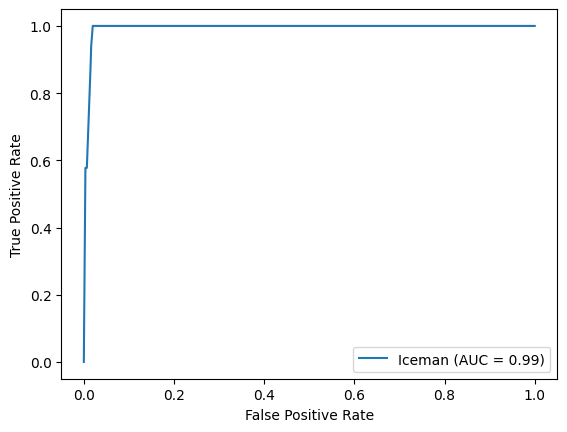

0.436


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

S = np.concatenate((distances_X_test, distances_adversarial_examples))

fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Iceman')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = round(thresholds[optimal_idx],3)
print(threshold)

## Then we evaluate using Iceman! 

In [ ]:
def IDS(x, threshold):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions

In [ ]:
y_pred = IDS(test_set, threshold)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("Equal Error Rate: ", round(eer,3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.99 
F1-Score:  0.989 
MCC:  0.979
Rec:  0.979 
Prec:  1.0 
AUC:  0.994
Equal Error Rate:  0.02
True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 0.979
False Positive Rate (FPR): 0.021
False Negative Rate (FNR): 0.000


## Alert Management Stuff!

In [ ]:
true_positives = X_test_res_scaled[y_test_res == 1] # True Attack. Investigate!
true_negatives = X_test_res_scaled[y_test_res == 0] # True Benign. Do Nothing!
false_positives = [example for example, label in zip(adversarial_examples, true_labels) if label == 0] # Evasion (true_label = benign, pred = attack). Caution!
false_negatives = [example for example, label in zip(adversarial_examples, true_labels) if label == 1] # Evasion (true_label = attack, pred = benign). Investigate!

exp_newset = np.concatenate((true_positives, true_negatives, false_positives, false_negatives))
exp_newlab = np.concatenate((np.full(len(true_positives), 1), np.full(len(true_negatives), 0), np.full(len(false_positives), 3), np.full(len(false_negatives), 2)))

In [ ]:
def IDS_alert(x, threshold, filter = False):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            if pred == 1:
                predictions.append('tp' if filter else 1) # TP
            else:
                predictions.append('tn' if filter else 0) # TN
        else:
            if pred == 1:
                predictions.append('fp' if filter else 3) # FP
            else:
                predictions.append('fn' if filter else 2) # FN
    return predictions

In [ ]:
from sklearn.metrics import classification_report

y_pred = IDS_alert(exp_newset, threshold)

# Print classification report
print(classification_report(exp_newlab, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9894
           1       1.00      1.00      1.00      9894
           2       0.96      1.00      0.98     10080
           3       1.00      1.00      1.00     10800

    accuracy                           0.99     40668
   macro avg       0.99      0.99      0.99     40668
weighted avg       0.99      0.99      0.99     40668



In [ ]:
exp_newlab_filter = np.concatenate((np.full(len(true_positives), 'tp'), np.full(len(true_negatives), 'tn'), np.full(len(false_positives), 'fp'), np.full(len(false_negatives), 'fn')))

y_pred = IDS_alert(exp_newset, threshold, filter=True)

# Print classification report
print(classification_report(exp_newlab_filter, y_pred))

              precision    recall  f1-score   support

          fn       0.96      1.00      0.98     10080
          fp       1.00      1.00      1.00     10800
          tn       1.00      0.96      0.98      9894
          tp       1.00      1.00      1.00      9894

    accuracy                           0.99     40668
   macro avg       0.99      0.99      0.99     40668
weighted avg       0.99      0.99      0.99     40668



## Now we evaluate performance using VERITAS

In [ ]:
import veritas

def veritas_attack(model, samples, labels, epsilon, timeout=1, search_steps=100, verbose=False):
    adversarial_examples, true_labels = [], []
    assert len(np.unique(np.asarray(y_test))), "Input must be a binary-classification problem with labels 0/1"
    assert np.min(X_test_nr)>=0 and np.max(X_test_nr)<=1.0, "Input Dataset must be Min-Max Normalised"
    at = veritas.get_addtree(model)
    print("\nFinding Adversarial Examples using Veritas:")
    for i in tqdm(range(len(labels))):
        base_example = samples[i]
        true_label = labels[i]
        if model.predict([base_example]) != true_label:
            if verbose:
                print(i, "Skipping Misclassified Sample","\n")
            continue
        heur = veritas.HeuristicType.MAX_OUTPUT if true_label == 0 else veritas.HeuristicType.MIN_OUTPUT
        config = veritas.Config(heur)
        config.ignore_state_when_worse_than = 0.0
        prune_box = [veritas.Interval(max(0.0, x-epsilon), min(1.0, x+epsilon)) for x in base_example]
        search = config.get_search(at, prune_box)
        stop_reason = search.step_for(timeout, search_steps) 
        while search.num_solutions() == 0:
            if search.steps(search_steps) == veritas.StopReason.NO_MORE_OPEN or stop_reason:
                if verbose:
                    print(i, "Timeout & Skipped","\n") 
                break
        if search.num_solutions() > 0:
            sol = search.get_solution(0)
            adv_example = veritas.get_closest_example(sol, base_example, eps=1e-3)
            predicted_label = int(model.predict([adv_example]))
            l_inf = np.max(np.abs(base_example - adv_example))
            if int(predicted_label) != int(true_label) and l_inf < epsilon:
                adversarial_examples.append(adv_example)
                true_labels.append(true_label)
                if verbose:
                    print(i, "True Label:", str(true_label), "--> Adversarial Label:", str(predicted_label), "L-inf:", l_inf, "\n")
            else:
                if verbose:
                    print(i, "Debugging Needed","\n") 
        else:
            if verbose:
                pass
                print(i, "No Adversarial Example Found","\n")
    print("\nFound:", len(adversarial_examples), "| Split:", Counter(true_labels))
    return adversarial_examples, true_labels

In [ ]:
adversarial_examples, true_labels = veritas_attack(model1, np.asarray(X_test_nr), np.asarray(y_test_nr), 0.00015, 100, 5000)

SKLEARN: RF classifier with 1 classes

Finding Adversarial Examples using Veritas:


100%|██████████| 39/39 [00:00<00:00, 113.26it/s]


Found: 0 | Split: Counter()


Apparently, VERITAS could not find any adversarial examples! 

## Then we evaluate using GROOT!

In [ ]:
from groot.model import GrootRandomForestClassifier
forest = GrootRandomForestClassifier(n_estimators=50, max_depth=10, attack_model = [0.00015] * X_train_res_scaled.shape[1], random_state=42, verbose=True, n_jobs=10)

forest.fit(np.asarray(X_train_res_scaled), np.asarray(y_train_res))


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   14.5s finished


GrootRandomForestClassifier(attack_model=[0.00015, 0.00015, 0.00015, 0.00015,
                                          0.00015, 0.00015, 0.00015, 0.00015,
                                          0.00015, 0.00015, 0.00015],
                            max_depth=10, n_estimators=50, n_jobs=10,
                            random_state=42, verbose=True)

In [ ]:
y_pred = forest.predict(test_set)

In [ ]:
from sklearn.metrics import roc_auc_score

print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc_score(y_pred, test_lab), 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.876 
F1-Score:  0.855 
MCC:  0.775
Rec:  1.0 
Prec:  0.747 
AUC:  0.902
True Positive Rate (TPR): 0.747
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.253


## Then we evaluate using OC-Score!

In [ ]:
ytrain_pred = model1.predict(X_train_res_scaled) # For the Reference Set
acc_train = accuracy_score(y_train_res, ytrain_pred)
print(f"Training Accuracy: {acc_train:.3f}")

Training Accuracy: 1.000


In [ ]:
# Find a reference set, e.g. set of correctly classified training examples
xref_mask = ytrain_pred == y_train_res
xref = X_train_res_scaled[xref_mask]
dtype = np.uint16
idref_train = model1.apply(xref).astype(dtype)

In [ ]:
idref_exp = model1.apply(test_set).astype(dtype)

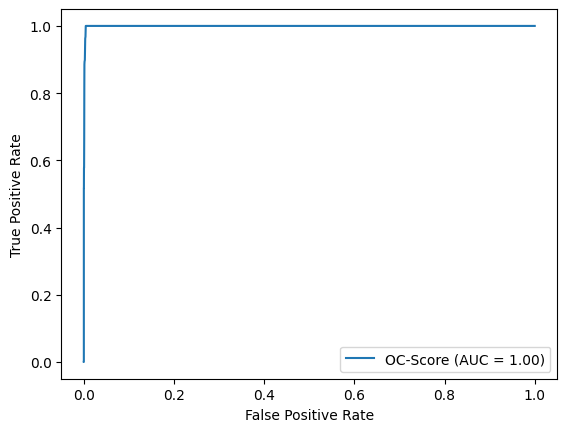

13


In [ ]:
import ocscore

S = ocscore.ocscores(idref_train, idref_exp)

fpr, tpr, thresholds = roc_curve(test_lab_sym, S, drop_intermediate = False)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OC-Score')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = round(thresholds[optimal_idx], 3)
print(threshold)

In [ ]:
def OC_predict(x, refset, threshold):
    testset = model1.apply(x).astype(dtype)
    S = ocscore.ocscores(refset, testset)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions

In [ ]:
y_pred = OC_predict(test_set, idref_train, threshold)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.982 
F1-Score:  0.981 
MCC:  0.964
Rec:  1.0 
Prec:  0.963 
AUC:  0.999
True Positive Rate (TPR): 0.963
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.037


## Timing Experiments!

In [ ]:
runs = 100

In [ ]:
times_3_iceman = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = IDS(test_set, threshold=0.4997)
    times_3_iceman.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_3_iceman.pkl', 'wb') as f:
    pickle.dump(times_3_iceman, f)
print("Complete!")

Complete!


In [ ]:
times_3_groot = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = forest.predict(test_set)
    times_3_groot.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_3_groot.pkl', 'wb') as f:
    pickle.dump(times_3_groot, f)
print("Complete!")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:12<00:00,  7.78it/s]

Complete!


In [ ]:
times_3_ocscore = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = OC_predict(test_set, idref_train, threshold)
    times_3_ocscore.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_3_ocscore.pkl', 'wb') as f:
    pickle.dump(times_3_ocscore, f)
print("Complete!")

Complete!
